<center>
<h1>
Optimal Academic Funding
</h1>

<h3>
Tu Anh Nguyen
</h3>
<h4>
Tarleton State University, Stephenville, TX
</h4>
<h4>
12/04/2017
</h4>

</center>

# Introduction

This project is a preliminarily research on exploring effect of varying funding levels. Our goal is to find an optimal distribution of funding so that the number of paper produced each year are optimized. Please note that, this research only focuses on academic papers that are in Science, technology, engineering, and mathematics (STEM). We hope to expand our reseach into other disciplin to have a broader picture.

## Data Collection

The data we use for this project is collected fron arXiv (https://arxiv.org/). The arXiv is a repository that contains papers from Physics, Mathematics, Computer Science, Quantitative Biology, Quantitative Finance, Statistics, Electrical Engineering and Systems Science, and Economics. For each paper in arXiv, we collect the following data,

1. doi
1. Publishing date
1. Title
1. Author names
1. Main Field

According to https://arxiv.org/help/bulk_data, there are 3 services that we can use for colleting the data from arXiv. They are `OAI-PMH`, `arXiv API`, and `RSS`. Our fist approach was using the arXiv. However, there are inconsistency in the category values because of the recent changes in the naming system for category. Furthermore, `arXiv API` was not desgined for accessing the whole arXiv repository. Thus, we use `OAI-PMH` to acces the metadata for every paper in the arXiv repository. 

### Data Collection Process

We use the `urllib` to request a `url` link that serves as the query interface for arXiv's `OAI-PMH`. After the request, arXiv's server will return a text strings in `XML` format that contains the results for the report. We use the `BeautifulSoup` package to parse the data. Each query returns at most 1,000 results. If there are more than, 1,000 results, arXiv will provide a `resumptionToken` that can be used for continue to the next 1,000 results. The python code for the data collection process is provided in the appendix. The data collected are exported into a csv file, which can be acceses at https://www.dropbox.com/s/mxlqmphe9dxtw8y/data_v3.csv?dl=1. Please note that the size of this files is (371M)

## Data Exploration

In order to process the data, we need to import important packages. 

1. We use `pandas` for parsing csv files and organizing data
1. We use `numpy` as our advance calculation tool
1. we use `matplotlib.pyplot` for the visualization of our result

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Since the data is too big for github. We have to host our data using dropbox. Once, we have downloaded the data to our local machine, we can change `download` to `False` in order to avoid having do download the data gain.

In [2]:
# Download and import data
download = False # If download is true download and save data, else just read data

if(download):
    ## Data set
    data_url = "https://www.dropbox.com/s/mxlqmphe9dxtw8y/data_v3.csv?dl=1"
    df = pd.read_csv(data_url)
    df.to_csv("data.csv", index = False)
else:
    df = pd.read_csv("data.csv")

Since there might be duplications and `NaN` in the dataset, we uses pandas `dropna` and `drop_duplicates` to remove them from our data frame (`df`). Furthermore, we also use `drop` to remove the index value from the csv file. The reason why we drop duplicate is to avoid the double counting of the same authors with the same paper. We drop duplicates based on `title` and we will keep the last paper. This is because the authors can submit different version of the paper. Thus, the last one is the most recent version of the paper. Furthermore, because this is an early stage of the project, we have not think about how to properly deal with `NaN` data. Thus, we just remove them.

In [4]:
# Cleaning the dataframe
df.dropna(inplace = True)
df.drop_duplicates(subset = "title", keep = "last", inplace = True)

try:
    df.drop("Unnamed: 0", axis = 1, inplace = True) # Drop the "Unnamed: 0"
except:
    pass

df.head()

,doi,date,title,authors,category
2,oai:arXiv.org:0704.0047,2007-04-01,Intelligent location of simultaneously active ...,Kosel T.;Grabec I.,cs
3,oai:arXiv.org:0704.0050,2007-04-01,Intelligent location of simultaneously active ...,Kosel T.;Grabec I.,cs
4,oai:arXiv.org:0704.0062,2007-03-31,On-line Viterbi Algorithm and Its Relationship...,Šrámek Rastislav;Brejová Broňa;Vinař Tomáš,cs
7,oai:arXiv.org:0704.0108,2007-04-01,Reducing SAT to 2-SAT,Gubin Sergey,cs
8,oai:arXiv.org:0704.0213,2007-04-02,Geometric Complexity Theory V: On deciding non...,Narayanan Ketan D. Mulmuley Hariharan,cs


We formated the `authors` columns so that different authors are separated by ";" (semicolon). Thus, we can loop through each row and separate the author using the `split(";")` command. We will collect and find the unique set of authors. Then, we can use a dictionary to produce a mapping from the name of an author to an integer number, which will be used as an index of the author in the credit matrix. Similarly, we produce another dictionary for category to create a mapping from a category to an integer number, which will be used as an index in the credit matrix. Please note that, both the author list (`au_lst`) and category list (`all_cat`) are sorted before we use it to produce a dictionary.

In [5]:
# Collecting all the aurhors
au_lst = []
for paper_authors in df["authors"].values:
    for author in paper_authors.split(";"):
        au_lst.append(author)
        
# Get all the unique authors       
au_lst = list(set(au_lst))
au_lst.sort()


# Get the category list from the data frame.
all_cat = list(set(df["category"].values))
all_cat.sort() 

au_dict = {author:index for (index, author) in enumerate(au_lst)}
cat_dict = {cat:index for (index, cat) in enumerate(all_cat)}

### Credit Matrix ($C$)

In this step, we will produce a credit matrix ($C$), which contains the infomation about the authors contribution to each field interm of paper written. In particular, $C_{ij}$ represent author$_j$'s contribution to field$_j$. The procedure for calculating this contribution is: 

For each paper

1. Count the total number of author, which will be stored as $n$
1. Assign the contribution for each author in the paper to be $\frac{1}{n}$

Here, we initialize the credit matrix. It has 

- $n$ rows such that $n$ is the number of unique authors
- $p$ columns such that $p$ is the number of unique categories

Then, we use a for loop to loop through all the paper in (`df`), then we follow the procedure for calculating contribution described above. The two dictionaries `au_dict` and `cat_dict` will provide the corresponding index for each author and the category for the credit matrix.

In [6]:
# Creating the matrix
n = len(au_dict)
p = len(all_cat)
credit_matrix = np.zeros((n, p))

for index, row in df[["authors", "category"]].iterrows():
    
    author_list = row["authors"].split(";")
    contribute = 1.0/len(author_list)
    
    for author in author_list:
        try:
            credit_matrix[ au_dict[author], cat_dict[row["category"]] ] += contribute
        except KeyError as e:
            print(e)

### Author Activity ($A$)

For each author, we are interested in the distrubution of his or her work in each field. Thus, we create the author activity matrix ($A$) such that $A_{ij}$ represents the portion of contribution of author $i$ to field $j$ with respect to his or her total contribution. We produce this matrix by dividing each entry in $C$ by the sum of that entry's row.

In [7]:
author_activity = credit_matrix / credit_matrix.sum(axis=1, keepdims=True)

### Author Weight in Field ($W$)

We are also interested in how much weight does each author has in each field. Thus, we create the author weight infield matrix ($W$) such that $W_{ij}$ represents the portion of contribution of author $i$ to field $j$ with respect to the total contribution of the whole field. We produce this matrix by dividing each entry in $C$ by the sum of that entry'columns

In [8]:
author_weight_in_field = credit_matrix / credit_matrix.sum(axis=0, keepdims=True)

### Field Funding ($F$)

This project investigate the influence of field funding distribution. Thus, we need information about the funding for each field. Unfortunately, <span style="color:red"> we don't have this data </span>. Since this is just a preliminarily research project, we will generate this information using numpy `random.rand` function. Furthermore since $F$ represent the distribution of funding, we will normalize each entries in the randomly generated vector. 

In [9]:
num_field = len(all_cat)

# Current field funding - Generating a random funding
d = np.random.rand(num_field)
current_field_funding = d / d.sum()

### Author Funding ($F_a$)

We calculate each author's funding by using $W$. In this way, author with more weight will have more funding. In particular 

$$F_a = F \circ W.$$

Note that $\circ$ represent an element-wise product between two matrices.

### Author Productivity ($P$)

We define a author productivity $p$ as an author ability to generate credit for each dollar. We calculate this by dividing the credit matrix $C$ by the author's funding ($F_a$). This matrix is invariance thorughout the simulation process.

### Hypothesis about the interaction between field funding and total credit

Generally, author with more funding can produce more paper. In this project, we use the two matrices $P$ and $F_a$ to compute the credit that are newly produced using the new funding. In particular, 

$$C = P \circ F_a.$$

### Function for updating funding and credit

Below are the two functions that we use to calculate $F_a$ and $C$ for different current credit ($C$) and field funding level $F$.

In [10]:
def update_author_funding(credit, field_funding):
    
    '''
    Function to calculate the author funding
    
    INPUT: 
        - credit        : author current credit matrix
        - field_funding : the current funding distribution
    
    OUTPUT:
        - author funding : the funding for each author based on their weigh in the field
    '''
    
    author_weight_in_field = credit / credit.sum(axis=0,keepdims=True)
    author_funding_from_field = author_weight_in_field * field_funding
    author_funding = author_funding_from_field.sum(axis=1,keepdims=True)
    return author_funding

def compute_credit(author_funding):
    
    '''
    Function to calculate the credit 
    
    INPUT:
        - author_funding : the funding of author
    OUTPUT:
        - new_credit   : the new updated credit matrix, 
                         which is calculated by the author productivity and author funding
        - total_credit : the sum of all the credits in the credit matrix
    '''
    
    new_credit = author_prod * author_funding
    field_credit = new_credit.sum(axis=0)
    author_credit = new_credit.sum(axis=1)
    total_credit = new_credit.sum()
    return new_credit, total_credit

### Gradient Ascend

Since the gradient vector point to the greatest rate of change, we can utlize this to optimize the total of credit produced with respect to the field funding $F$. In particular, for this project, our objective function is.

\begin{align}
    \sum_{i=1}^{n}\sum_{h=1}^{p} C_{ij},
\end{align}

$n$ are the number of authors and $p$ are the number of fields.

From our hypothesis, we have that 

$$C_{new} = P \circ F_a.$$

Further more, we also have that

$$F_a = F \circ W.$$

As a result, we have that for each $i$, $j$,

$$C_{ij} = P_{i}W_{ij}F_{j} \quad (1)$$

Using (1), we have the gradient as

$$\triangledown = \sum_{j=1}^{p} \frac{\partial C_{ij}}{\partial F_j}$$

As a result our alogrithm for optimizing the total number of credit is:

1. Calculate the gradient
1. Change the $F$ vector using the gradient vector
1. Repeat until the total number of credit converge

When we make adjustment to $F$ using the gradient vector, we have the learning rate $aplha$ and a probability $p$. 

- $alpha$ is how big of the step is
- $p$ is a probability that the change in $F$ does not follow the gradient.

In [20]:
num_steps = 200

# Learning hyperparameter
p = 0.05
alpha = 0.1

# Current credit
current_credit = credit_matrix

# Saving the original field funding 
original_field_funding = current_field_funding.copy()

In [21]:
# Initial calculation
current_author_funding = update_author_funding(current_credit, current_field_funding)
author_prod = current_credit / current_author_funding # This is invariance
current_credit, current_total_credit = compute_credit(current_author_funding)

# Initialize the best state
best_field_funding = current_field_funding.copy()
best_credit        = current_credit.copy()
best_total_credit  = current_total_credit.copy()

tot_credit_lst = []

In [22]:
for i in range(num_steps):
    current_author_weight_in_field = current_credit / current_credit.sum(axis=0,keepdims=True)

    if(np.random.rand() < 0.05):
        gradient = np.random.rand(num_field)
    else:
        gradient = (author_prod * current_author_weight_in_field).sum(axis = 0)

    gradient_norm = gradient/(sum(gradient))  # normalize
    # Update field funding
    new_field_funding = current_field_funding + alpha*gradient_norm
    new_field_funding = new_field_funding / (sum(new_field_funding)) # normalize 

    new_author_funding = update_author_funding(current_credit, new_field_funding)
    new_credit, new_total_credit = compute_credit(new_author_funding)
    
    tot_credit_lst.append(new_total_credit)
    
    # update the new best result
    if(best_total_credit < new_total_credit):
        best_field_funding = new_field_funding.copy()
        best_credit        = new_credit.copy()
        best_total_credit  = new_total_credit.copy()

    # Update for new step 
    current_field_funding = new_field_funding.copy()
    current_credit        = new_credit.copy()

#### 

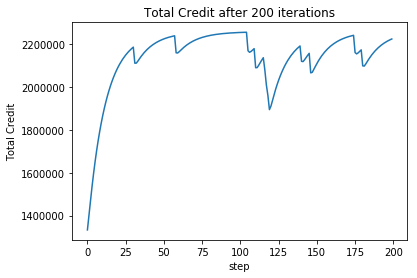

In [24]:
plt.plot(tot_credit_lst)
plt.ylabel('Total Credit')
plt.xlabel('step')
plt.title('Total Credit after 200 iterations')
plt.show()

We can see from the plot above that the total credit converge fairly quickly. In particular, it usally converge after about 200 iterations. Futhermore, we also notice that the optimal funding level is sensitive to the initial condtion, which is the initial funding level. This is because we use the initial funding level to calculate the author productivity, which is used for the calculation of new credit matrix. In order to develope this project further, we need to find a way to find the funding distribution among the fields. 

### Optimal funding distribution

In [25]:
funding_df = pd.DataFrame(best_field_funding, columns = ["Field Funding"], index = all_cat)
funding_df.sort_values(by="Field Funding", ascending = False)

,Field Funding
math,0.170098
physics:cond-mat,0.138665
cs,0.097203
physics:hep-ph,0.088238
physics:physics,0.085335
physics:hep-th,0.081142
physics:quant-ph,0.076672
physics:astro-ph,0.053113
physics:gr-qc,0.050239
stat,0.043085


# Appendix

This is the python code used for scraping the data from the arXiv repository using `OAI-PMH`.
```python
# Import for processing XML
from bs4 import BeautifulSoup
import time

# Import for requesting HTML
import urllib
import urllib.request
from urllib.error import HTTPError

# Import for text processing
import io
import re

# Import for data processing and organization
import pandas as pd
import numpy as np

# Find all the categories
url = "http://export.arxiv.org/oai2?verb=ListSets"
u = urllib.request.urlopen(url, data = None)
f = io.TextIOWrapper(u,encoding='utf-8')
text = f.read()
soup = BeautifulSoup(text, 'xml')
all_cat = [sp.text for sp in soup.findAll("setSpec")]

# Export the categories to a txt files
f = open("all_cat_v01.txt", "w")
f.write(",".join(all_cat))
f.close()

def scrape(cat):

    '''
    Function to scrape all the paper from a category

    INPUT : category (String)
    OUTPUT: dataframe that contains doi, date, title, authors, category for each paper (pandas.DataFrame)
    '''

    # Initialization
    df = pd.DataFrame(columns=("doi", "date", "title", "authors", "category"))
    base_url = "http://export.arxiv.org/oai2?verb=ListRecords&"
    url = base_url + "set={}&metadataPrefix=arXiv".format(cat)

    # while loop in order to loop through all the resutls
    while True:
        # print url to keep track of the progress
        print(url)
        # accessing the url
        try:
            u = urllib.request.urlopen(url, data = None)
        except HTTPError as e:
            # Incase of some error that require us to wait
            if e.code == 503:
                to = int(e.hdrs.get("retry-after", 30))
                print("Got 503. Retrying after {0:d} seconds.".format(to))
                time.sleep(to)
                continue # Skip this loop, continue to the next one
            else:
                raise

        # read the request
        f = io.TextIOWrapper(u,encoding='utf-8')
        text = f.read()
        soup = BeautifulSoup(text, 'xml')

        # collect the data
        for record in soup.findAll("record"):
            try:
                doi = record.find("identifier").text
            except:
                doi = np.nan

            try:
                date = record.find("created").text
            except:
                date = np.nan

            try:
                title = record.find("title").text
            except:
                title = np.nan

            try:
                authors = ";".join([author.get_text(" ") for author in record.findAll("author")])
            except:
                authros = np.nan

            try:
                category = record.find("setSpec").text
            except:
                category = np.nan

            df = df.append({"doi":doi, "date":date, "title":title, "authors":authors, "category":category},\
                           ignore_index=True)


        # resumptionToken help to find if there are more results
        token = soup.find("resumptionToken")
        if token is None or token.text is None:
            break
        else:
            url = base_url + "resumptionToken=%s"%(token.text)

    return(df)

# Initialize master_df that contains all the data points
master_df = pd.DataFrame(columns=("doi", "date", "title", "authors", "category"))
for i in all_cat:
    # Print out the current category for progress tracking
    print("----------------",i,"-------------------")
    df = scrape(i)
    # append the new data to master_df
    master_df = master_df.append(df, ignore_index = True)

# Export the data to a csv file
master_df.to_csv("data.csv")
```